In [2]:
import numpy as np
import pandas as pd

In [3]:
financial_data = pd.read_csv("financial_data.csv")

In [4]:
from zlib import crc32

In [5]:
financial_data["Company_ID"] = (financial_data["Total Assets"] * 1000 + financial_data["Total Liabilities"]).astype(int)

In [6]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [7]:
train_set, test_set = split_data_with_id_hash(financial_data, 0.2, "Company_ID")

In [8]:
train_set.to_csv("train_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)

In [9]:
len(train_set), len(test_set)

(9654, 2346)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

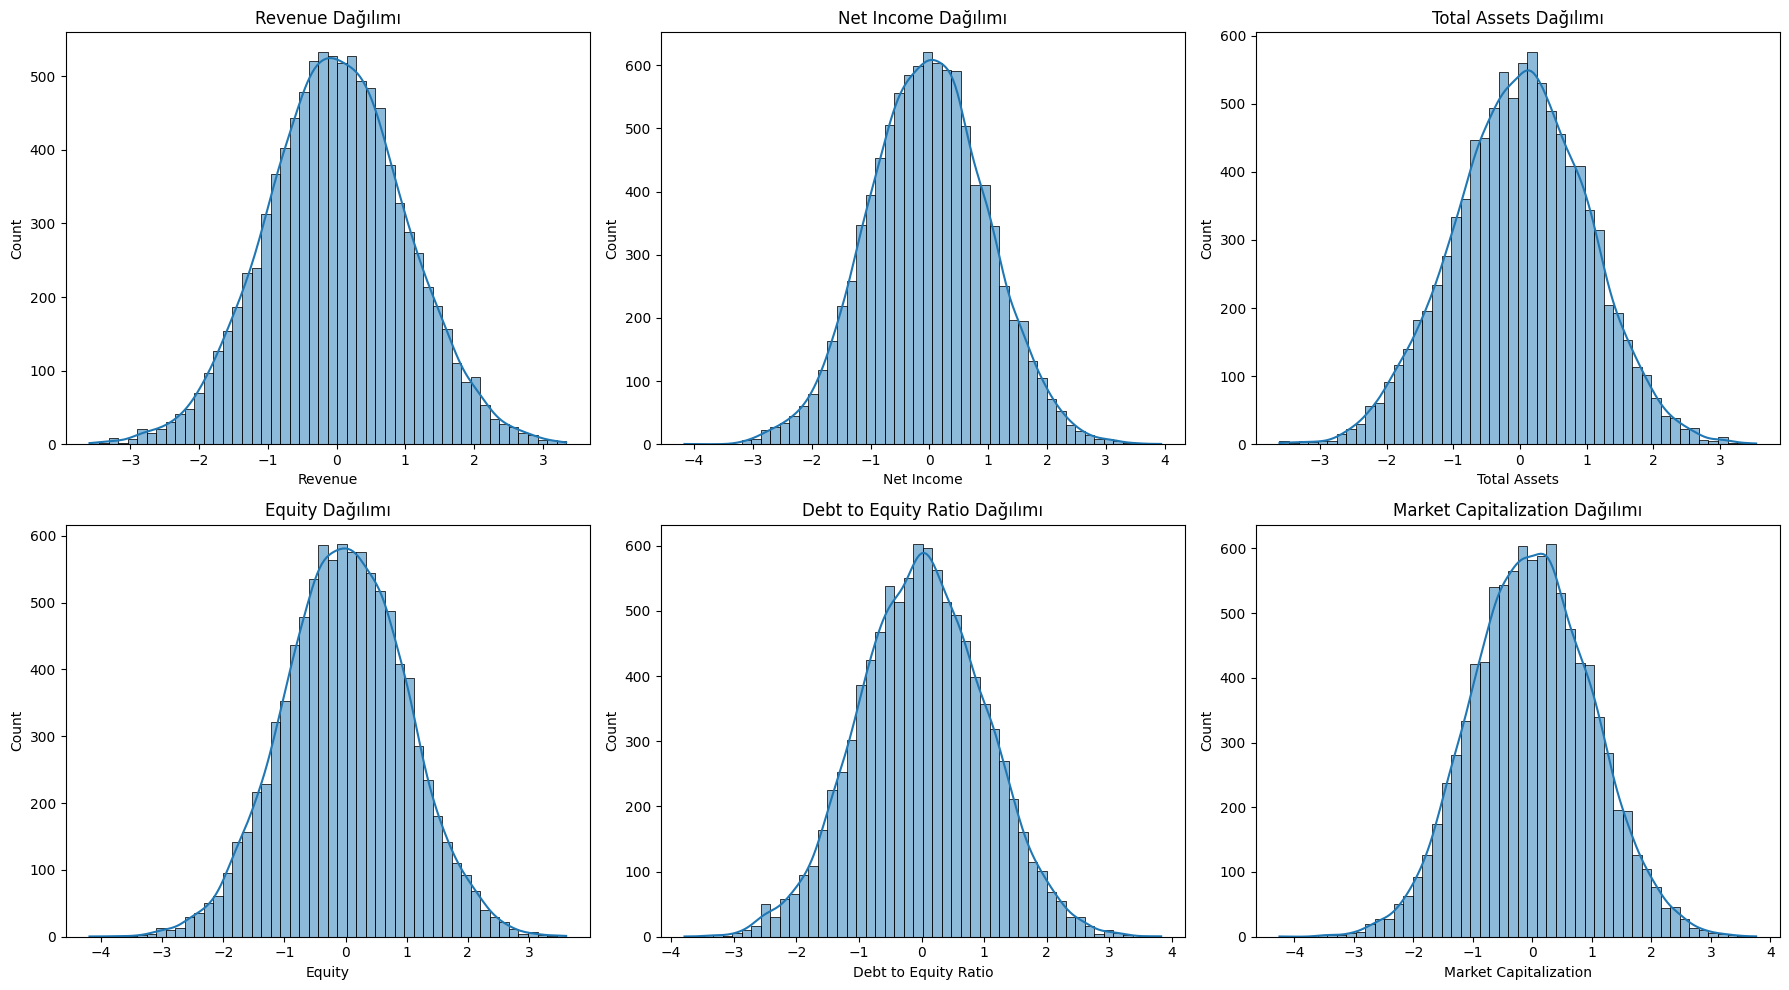

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.histplot(train_set["Revenue"], bins=50, kde=True, ax=axes[0, 0]).set(title="Revenue Dağılımı")
sns.histplot(train_set["Net Income"], bins=50, kde=True, ax=axes[0, 1]).set(title="Net Income Dağılımı")
sns.histplot(train_set["Total Assets"], bins=50, kde=True, ax=axes[0, 2]).set(title="Total Assets Dağılımı")
sns.histplot(train_set["Equity"], bins=50, kde=True, ax=axes[1, 0]).set(title="Equity Dağılımı")
sns.histplot(train_set["Debt to Equity Ratio"], bins=50, kde=True, ax=axes[1, 1]).set(title="Debt to Equity Ratio Dağılımı")
sns.histplot(train_set["Market Capitalization"], bins=50, kde=True, ax=axes[1, 2]).set(title="Market Capitalization Dağılımı")
plt.tight_layout()
plt.show()


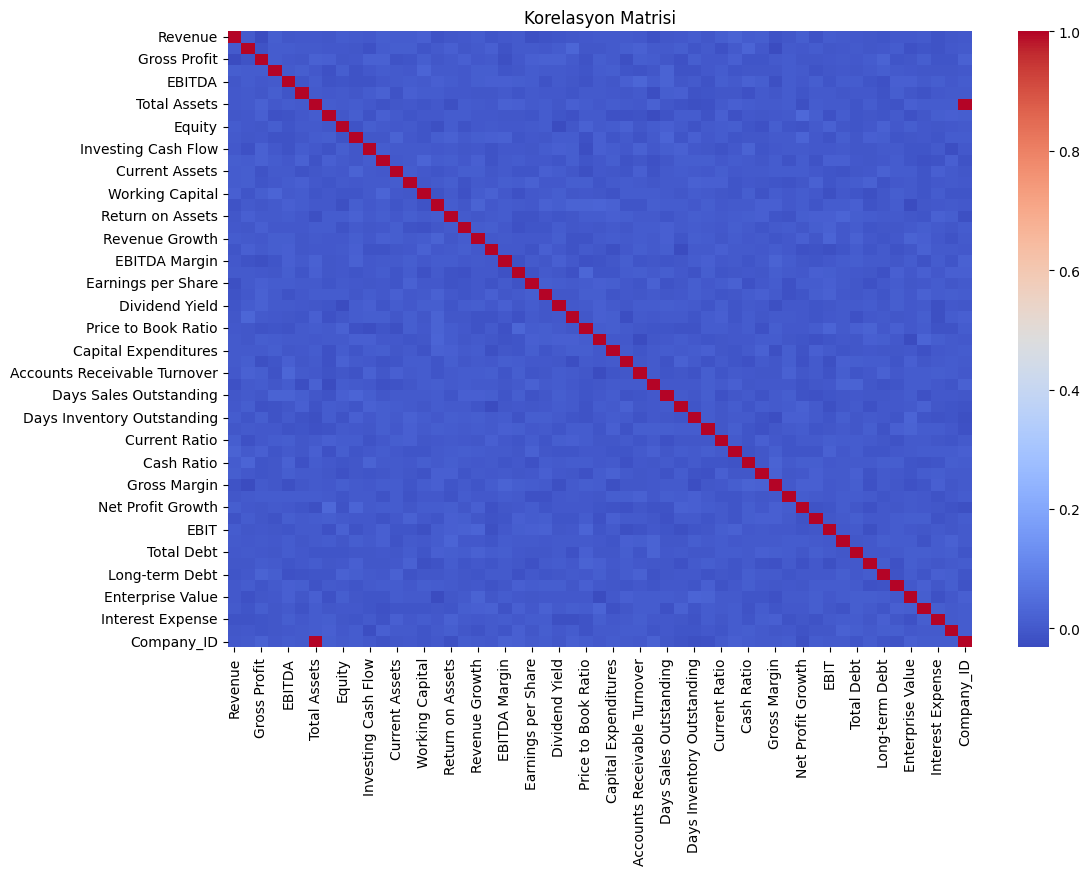

In [12]:
plt.figure(figsize=(12, 8))
correlation_matrix = train_set.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Korelasyon Matrisi")
plt.show()


In [13]:
def add_features(data):
    data = data.copy()
    data["EBITDA_Margin"] = data["EBITDA"] / data["Revenue"]
    data["ROA"] = data["Net Income"] / data["Total Assets"]
    data["ROE"] = data["Net Income"] / data["Equity"]
    data["CashFlow_to_Debt"] = data["Operating Cash Flow"] / data["Total Debt"]
    data["DSCR"] = data["EBITDA"] / data["Interest Expense"]
    data["FCF"] = data["Operating Cash Flow"] - data["Capital Expenditures"]
    data["Inventory_Turnover"] = data["Cost of Goods Sold"] / (data["Total Assets"] - data["Equity"])
    data["DSO"] = data["Accounts Receivable Turnover"] / (data["Revenue"] / 365)
    data["P_B_Ratio"] = data["Market Capitalization"] / data["Equity"]
    return data

In [14]:
train_set = add_features(train_set)
test_set = add_features(test_set)

train_set.to_csv("train_set_processed.csv", index=False)
test_set.to_csv("test_set_processed.csv", index=False)

print(f"Eğitim Seti Boyutu: {len(train_set)}")
print(f"Test Seti Boyutu: {len(test_set)}")

Eğitim Seti Boyutu: 9654
Test Seti Boyutu: 2346


In [15]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer

In [16]:
numerical_features = [
    "Revenue", "Net Income", "Total Assets", "Equity", "Market Capitalization", 
    "EBITDA_Margin", "ROA", "ROE", "CashFlow_to_Debt", "DSCR", "FCF", "Inventory_Turnover", "DSO", "P_B_Ratio"
]

In [17]:
scaler = StandardScaler()
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [18]:
log_features = ["Revenue", "Total Assets", "Equity", "Market Capitalization"]

In [19]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [20]:
train_set_scaled[log_features] = log_transformer.fit_transform(train_set_scaled[log_features])
test_set_scaled[log_features] = log_transformer.transform(test_set_scaled[log_features])

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:394: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:394: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


In [21]:
train_set_scaled[numerical_features] = scaler.fit_transform(train_set_scaled[numerical_features])
test_set_scaled[numerical_features] = scaler.transform(test_set_scaled[numerical_features])

In [22]:
train_set_scaled.to_csv("train_set_processed.csv", index=False)
test_set_scaled.to_csv("test_set_processed.csv", index=False)

In [23]:
print(f"Eğitim Seti Boyutu: {len(train_set_scaled)}")
print(f"Test Seti Boyutu: {len(test_set_scaled)}")

Eğitim Seti Boyutu: 9654
Test Seti Boyutu: 2346


In [24]:
from sklearn.impute import SimpleImputer

In [25]:
imputer = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(imputer.fit_transform(train_set_scaled[numerical_features]), columns=numerical_features)
X_test = pd.DataFrame(imputer.transform(test_set_scaled[numerical_features]), columns=numerical_features)



In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [27]:
roa_25 = train_set_scaled["ROA"].quantile(0.25)
roa_75 = train_set_scaled["ROA"].quantile(0.75)

In [28]:
def classify_company(ROA):
    if ROA < roa_25:
        return 0  
    elif ROA > roa_75:
        return 2  
    else:
        return 1  

In [29]:
train_set_scaled["Performance_Class"] = train_set_scaled["ROA"].apply(classify_company)
test_set_scaled["Performance_Class"] = test_set_scaled["ROA"].apply(classify_company)

In [30]:
y_train = train_set_scaled["Performance_Class"]
y_test = test_set_scaled["Performance_Class"]

In [31]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [32]:
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1], 'kernel': ['rbf']}
svm_grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [33]:
best_model = svm_grid.best_estimator_
y_pred = best_model.predict(X_test)


In [34]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [35]:
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Model Accuracy: 0.9339
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       587
           1       0.93      0.94      0.93      1156
           2       0.95      0.93      0.94       603

    accuracy                           0.93      2346
   macro avg       0.94      0.93      0.93      2346
weighted avg       0.93      0.93      0.93      2346

Confusion Matrix:
 [[ 546   40    1]
 [  38 1087   31]
 [   0   45  558]]


In [36]:
import joblib

In [39]:
joblib.dump(best_model, "svm_financial_model.pkl")


['svm_financial_model.pkl']